In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [56]:
# Input Image
IMAGE = "bw_photo3.jpg"

In [57]:
prototxt = "./model/colorization_deploy_v2.prototxt"
model = "./model/colorization_release_v2.caffemodel"
points = "./model/pts_in_hull.npy"
image =  "./input_images/"+IMAGE

In [58]:
net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(points)

In [59]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [60]:
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

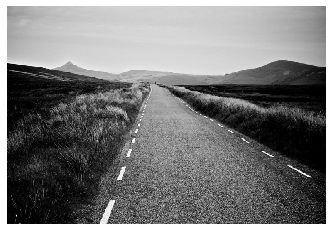

In [61]:
plt.imshow(image)
plt.axis('off');

In [62]:
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

In [63]:
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

In [64]:
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


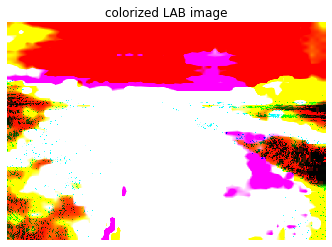

In [65]:
plt.imshow(colorized)
plt.axis('off');
plt.title('colorized LAB image');

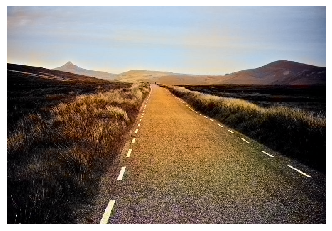

In [66]:
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")
plt.imshow(colorized)
plt.axis('off');